In [2]:
!ls /Users/sampathm/Downloads/demo/ | head

$_35 (7).JPG
$_35 (7).JPG_act.jpg
$_35 (7).JPG_predict.jpg
$_35 (7).txt
-Recibo-de-efectivo-del-papel-termal-Rolls.jpg
-Recibo-de-efectivo-del-papel-termal-Rolls.jpg_act.jpg
-Recibo-de-efectivo-del-papel-termal-Rolls.jpg_predict.jpg
-Recibo-de-efectivo-del-papel-termal-Rolls.txt
0021.jpg
0021.jpg_act.jpg


In [7]:
from glob import glob

In [12]:
glob('/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook*')

['/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg_act.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg_predict.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.txt']

In [35]:
"""
Given EAST - Text File & Image - we can corner the image.
"""

import cv2
import matplotlib.pyplot as plt
import numpy as np


def get_slope(x2, x3, y2, y3):
    if x3 - x2 == 0:
        return 'infinity'
    return ((y3 - y2) * 1.0) / (x3 - x2)


def read_data(text_filename):
    raw_data = []
    bag = []
    data = open(text_filename).read().splitlines()
    for line in data:
        x1, y1, x2, y2, x3, y3, x4, y4 = list(map(round, map(float, line.split(','))))
        raw_data.append((x1, y1, x2, y2, x3, y3, x4, y4))
        _x = [x1, x2, x3, x4]
        _y = [y1, y2, y3, y4]
        x_max = max(_x)
        x_min = min(_x)
        y_max = max(_y)
        y_min = min(_y)
        coords = [y_min, y_max, x_min, x_max]
        bag.append(coords)
    return raw_data, bag


def get_box_slaves(x1, y1, x2, y2, x3, y3, x4, y4):
    slopes = (get_slope(x1, x2, y1, y2),
              get_slope(x2, x3, y2, y3),
              get_slope(x3, x4, y3, y4),
              get_slope(x4, x1, y4, y1))
    return slopes


def get_all_slopes(raw_data):
    for x1, y1, x2, y2, x3, y3, x4, y4 in raw_data:
        slopes = get_box_slaves(x1, y1, x2, y2, x3, y3, x4, y4)
        print(slopes)


def get_plot_points(raw_data):
    plot_points = []
    for x1, y1, x2, y2, x3, y3, x4, y4 in raw_data:
        plot_points += [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x1, y1)]
    return plot_points


def length(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y2 - y1) ** 2) ** 0.5


def get_area(x1, y1, x2, y2, x3, y3, x4, y4):
    lenghts = [length(x1, y1, x2, y2),
               length(x2, y2, x3, y3),
               length(x3, y3, x4, y4),
               length(x4, y4, x1, y1)
               ]
    side_a = (lenghts[0] + lenghts[2]) / 2
    side_b = (lenghts[1] + lenghts[3]) / 2
    return side_a, side_b, round(side_a * side_b, 2)


def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped


def trim_outliers1(raw_data):
    new_plot_points = []
    stats = []
    plot_points = []
    mins_box_lengths = []

    for each in raw_data:
        x1, y1, x2, y2, x3, y3, x4, y4 = each
        _points = [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x1, y1)]
        plot_points += _points
        side_a, side_b, tot_area = get_area(x1, y1, x2, y2, x3, y3, x4, y4)
        stats.append((side_a, side_b, tot_area))
        mins_box_lengths.append(min(side_a, side_b))

    _acceptable_min_lenght = np.quantile(sorted(mins_box_lengths), 0.50)
    # TODO - remove - too big or too small
    _acceptable_min_lenght = _acceptable_min_lenght * 1.5

    # find median - text length
    for i in range(len(stats)):
        side_a, side_b, tot_area = stats[i]
        if min((side_a, side_b)) < _acceptable_min_lenght:
            x1, y1, x2, y2, x3, y3, x4, y4 = raw_data[i]
            new_plot_points += [(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x1, y1)]
    return new_plot_points


def main(img_filename, text_filename):
    image = plt.imread(img_filename)
    raw_data, bag = read_data(text_filename)

    # for a line plot all the found point
    # plot_points = get_plot_points(raw_data)

    #  exception
    # new_plot_points = trim_outliers1(raw_data)
    #  exception - delete 1 corner region
    # plt.imshow(image)
    # plt.plot(*zip(*new_plot_points), 'b')
    # plt.plot(*zip(*new_plot_points[:-5]), 'g')
    new_plot_points = trim_outliers1(raw_data) [:-5]

    cnt = np.array(new_plot_points)
    # re-read image
    # image = plt.imread(img_filename)

    # cnt = np.array(new_plot_points)
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # plt.imshow(cv.drawContours(image,[box],0,(0,0,255),2))
    warped = four_point_transform(image, box)
    plt.figure(figsize=(10, 10))
    plt.imshow(warped)


# img_filename = '/Users/sampathm/devbox/vitaFlow/vitaflow/annotate_server/static/data/binarisation/2cqfj49.jpg'
# text_filename = '/Users/sampathm/devbox/vitaFlow/vitaflow/annotate_server/static/data/binarisation/2cqfj49.txt'

# main(img_filename, text_filename)

In [36]:
glob('/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook*')

['/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg_act.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg_predict.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.txt']

In [43]:
img_filename = '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg'
text_filename = '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.txt'

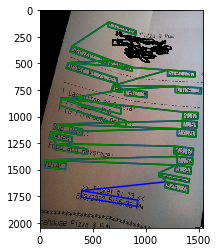

In [46]:
image = plt.imread(img_filename)
raw_data, bag = read_data(text_filename)

# for a line plot all the found point
# plot_points = get_plot_points(raw_data)

#  exception
# new_plot_points = trim_outliers1(raw_data)
#  exception - delete 1 corner region
plt.imshow(image)
plt.plot(*zip(*new_plot_points), 'b')
plt.plot(*zip(*new_plot_points[:-5]), 'g')


In [53]:
plt.imsave('/Users/sampathm/ocropy/facebook.jpg', warped)

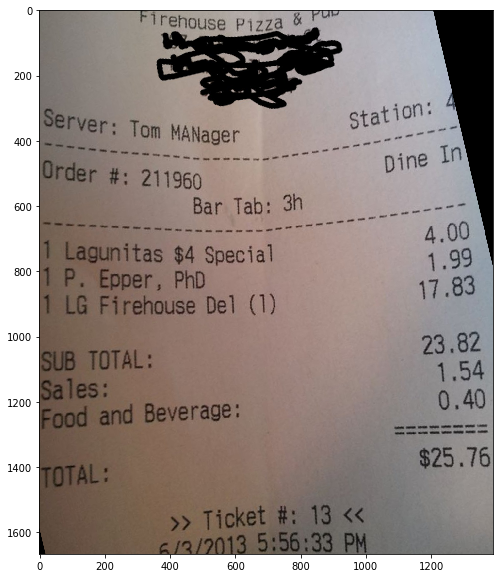

In [49]:


# cnt = np.array(new_plot_points)
rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect)
box = np.int0(box)

# plt.imshow(cv.drawContours(image,[box],0,(0,0,255),2))
warped = four_point_transform(image, box)
plt.figure(figsize=(10, 10))
plt.imshow(warped)


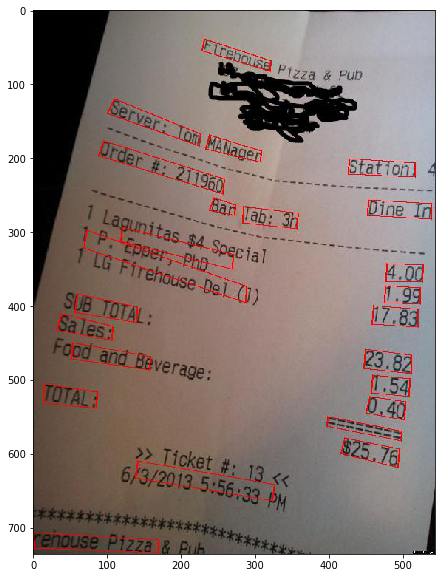

In [51]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg_predict.jpg'))

In [40]:
glob('/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook*')

['/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg_act.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.jpg_predict.jpg',
 '/Users/sampathm/Downloads/demo/o-DR-PEPPER-RECEIPT-facebook.txt']